In [1]:
using PyPlot
using PyCall
using FITSIO
using Interpolations
@pyimport camb
using Base.Iterators: take

## Parameters of the fiducial model:

In [2]:
Aₛ = exp(3.094)*1e-10
τ = 0.079
nₛ = 0.9645
H₀ = 67.27
h = H₀/100
ωb = 0.02225
ωc = 0.1198

kₚ = 0.05
T₀ = 2.7255;

## Compute transfer functions

Here we call CAMB to compute the CMB and matter transfer functions. Note we're computing them at every $\ell$ and at somewhat higher accuracy than normal, so this step may take a few minutes. 

In [3]:
p = camb.set_params(
    As=Aₛ, ns=nₛ, H0=H₀, ombh2=ωb, omch2=ωc, tau=τ, mnu=0.06, 
    pivot_scalar=kₚ, AccuracyBoost=2, lSampleBoost=50, TCMB=T₀, redshifts=[0], kmax=50, lmax=2600
)
r = camb.get_results(p)
t = r[:get_cmb_transfer_data]()
mt = r[:get_matter_transfer_data]();

In [4]:
ℓs = 1:2508
toCℓ = @. 1/(ℓs*(ℓs+1)/(2π))
CℓTT = @. 1e12*T₀^2 * r[:get_unlensed_scalar_cls](2508)[2:end,1] * toCℓ
CℓEE = @. 1e12*T₀^2 * r[:get_unlensed_scalar_cls](2508)[2:end,2] * toCℓ;
CℓTE = @. 1e12*T₀^2 * r[:get_unlensed_scalar_cls](2508)[2:end,4] * toCℓ;

Next, take the output from CAMB and put it in our matrix `Wkℓ` $\equiv W_\ell(k)$

$$
C_\ell = \int d\ln k \;W_\ell(k) P_*(k)
$$

where $P_*(k)$ is the primordial power spectrum. 

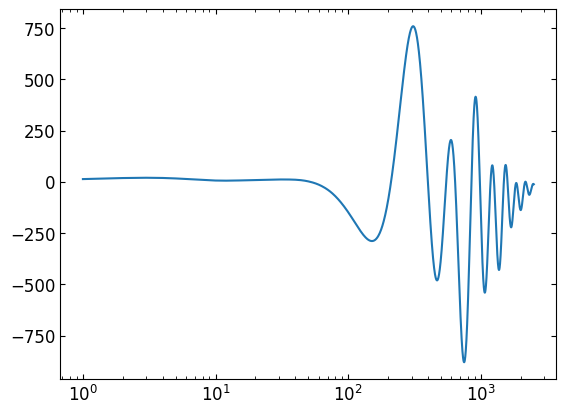

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f979061a390>

In [24]:
semilogx(CℓTE .* ℓs.^2)

In [33]:
ks = t[:q]
dlnk = diff(log.(ks))
dlnk = [dlnk[1]; dlnk];

WkℓTT = @. 4*pi*1e12*T₀^2 * t[:delta_p_l_k][1,:,:]^2
WkℓTT = [zeros(length(ks))'; WkℓTT][ℓs,:];

WkℓEE = @. 4*pi*1e12*T₀^2 * t[:delta_p_l_k][2,:,:]^2
WkℓEE = [zeros(length(ks))'; WkℓEE][ℓs,:] .* (ℓs.*(ℓs.+1)).^2;

WkℓTE = @. 4*pi*1e12*T₀^2 * t[:delta_p_l_k][1,:,:] .* t[:delta_p_l_k][2,:,:]
WkℓTE = [zeros(length(ks))'; WkℓTE][ℓs,:] .* (ℓs.*(ℓs.+1));

We can check this is right by doing the sum over $P_*(k)$ ourselves to verify we get the CMB spectrum back:

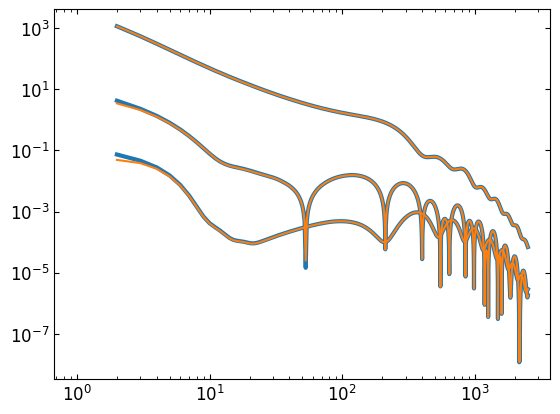

0-element Array{Any,1}

In [76]:
plot(ℓs,      WkℓTT * (Aₛ*(ks/kₚ).^(nₛ-1) .* dlnk),  lw=3, c="C0")
plot(ℓs,      WkℓEE * (Aₛ*(ks/kₚ).^(nₛ-1) .* dlnk),  lw=3, c="C0")
plot(ℓs, abs.(WkℓTE * (Aₛ*(ks/kₚ).^(nₛ-1) .* dlnk)), lw=3, c="C0")


plot(ℓs,      CℓTT,  c="C1")
plot(ℓs,      CℓEE,  c="C1")
plot(ℓs, abs.(CℓTE), c="C1")

loglog()

Similarly, the matter transfer functions, such that 
$$P(k) = T(k)^2 P_*(k)$$

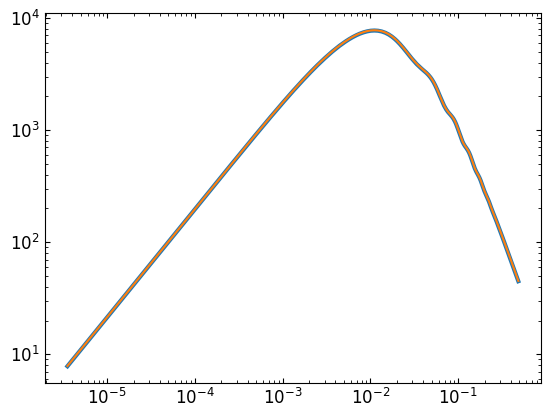

In [35]:
Tk² = interpolate((mt[:q],),mt[:transfer_data][7,:,1].^2 .* mt[:q],Gridded(Linear()))[ks] * 1.82 # <-- why the 1.82? 

mpk = r[:get_linear_matter_power_spectrum]()
mpk = interpolate((mpk[1],),mpk[3][:],Gridded(Linear()));
loglog(ks,Tk² .* (Aₛ*(ks/kₚ).^(nₛ-1)),lw=3)
loglog(ks,mpk[ks/h]*h^3);

## Load Planck data

In [36]:
# Planck bins
# lmax=2508
# planck = FITS("COM_PowerSpect_CMB_R2.02.fits")
# lims = zip((read(planck["TTHILBIN"],k) for k=["LMIN","LMAX"])...) |> collect
    
# log spaced
# ledge = map(x->round(Int,x),logspace(log10(2),log10(2500),20))
# lims = collect(zip(ledge[1:end-1],ledge[2:end]-1))#[8:end]
# B = hcat([(r=zeros(lmax); r[l1:l2]=1./(l1:l2); normalize!(r,1)) for (l1,l2)=lims]...);

# Tegmark bins
# lims = [(2, 2), (3, 5), (6, 10), (11, 30), (31, 75), (76, 125), (126, 175), (176, 225), (226, 275), (276, 325), (326, 375), (376, 425), (426, 475), (476, 525), (526, 575), (576, 625), (626, 675), (676, 725), (726, 775), (776, 825), (826, 1000), (1001, 1200), (1201, 1400), (1401, 1600)];
# B = hcat([(r=zeros(lmax); r[l1:l2]=1./(l1:l2); normalize!(r,1)) for (l1,l2)=lims]...);

### Low-ℓ

In [37]:
f = FITS("COM_PowerSpect_CMB_R2.02.fits")
tocl = 1./((2:29).*((2:29)+1)/2/pi)
d_low_TT = read(f["TTLOLUNB"],"D_ELL").*tocl
σ_low_TT = read(f["TTLOLUNB"],"ERRUP").*tocl
# σ_low = sqrt(read(f["TTLOLUNB"],"ERRUP").*read(f["TTLOLUNB"],"ERRDOWN")).*tocl
close(f)

### High-ℓ

In [70]:
# the binning specification
blmin, blmax = (round.(Int,readdlm("plik_lite_v18_TTTEEE.clik/clik/lkl_0/_external/bl$m.dat")) for m=["min","max"])
bweight = readdlm("plik_lite_v18_TTTEEE.clik/clik/lkl_0/_external/bweight.dat");
B_high = hcat([(r=zeros(2508); r[(30+lmin):(30+lmax)]=bweight[(1+lmin):(1+lmax)]; r) for (lmin,lmax) in take(zip(blmin,blmax),214)]...);


# the covariance
Σ_high = (open("plik_lite_v18_TTTEEE.clik/clik/lkl_0/_external/c_matrix_plik_v18.dat") do f
    read(f,Int32) #fortran header
    s = read(f,Float64,(613,613))
    (s+s') - diagm(diag(s))
end);
Σ_high_TT = Σ_high[1:214,1:214]
Σ_high_TE = Σ_high[216:414,216:414]
Σ_high_EE = Σ_high[415:end,415:end]


# the data
d_high_TT = readdlm("plik_lite_v18_TTTEEE.clik/clik/lkl_0/_external/cl_cmb_plik_v18.dat")[1:214,2]
d_high_TE = readdlm("plik_lite_v18_TTTEEE.clik/clik/lkl_0/_external/cl_cmb_plik_v18.dat")[216:414,2]
d_high_EE = readdlm("plik_lite_v18_TTTEEE.clik/clik/lkl_0/_external/cl_cmb_plik_v18.dat")[415:end,2];

In [39]:
# for TT, combine low and high-L    
n_low, n_high = length(d_low_TT), length(d_high_TT)
d_planck_TT = [d_low_TT; d_high_TT]
Σ_planck_TT = [diagm(σ_low_TT.^2) zeros(n_low,n_high); zeros(n_high,n_low) Σ_high_TT]
B_planck_TT = [[zeros(1,28); eye(2507,28)] B_high]

nbinsTT = size(B_planck_TT,2);
nbinsEE = size(B_high,2);

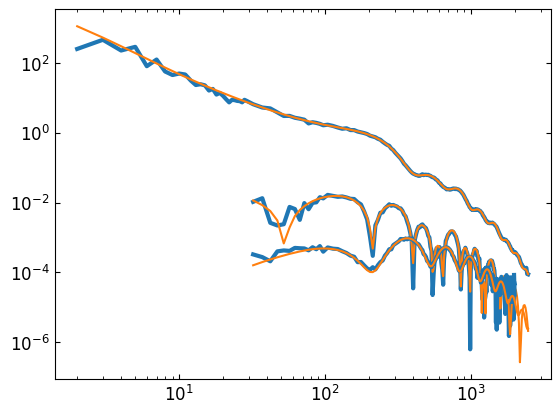

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f978170a780>

In [73]:
#check we loaded everything right
loglog((B_planck_TT'*ℓs), d_planck_TT, C="C0", lw=3)
plot(B_planck_TT'*ℓs, B_planck_TT'*CℓTT,c="C1")

loglog((B_high'*ℓs)[1:199], abs.(d_high_TE), c="C0", lw=3)
plot(B_high'*ℓs, B_high'*abs.(CℓTE),c="C1")

loglog((B_high'*ℓs)[1:199], d_high_EE, c="C0", lw=3)
plot(B_high'*ℓs, B_high'*CℓEE,c="C1")

## Make plot

In [67]:
function ebar(Pi)
    cs = cumsum(abs.(Pi) .* dlnk)
    cs /= cs[end]
#     semilogx(ks/h,cs)
    inz = @. (cs>0) & (cs<1)
    itp = interpolate((cs[inz],),ks[inz],Gridded(Linear()))
    itp[[0.2,0.5,0.8]]
end

function get_plot_data(d, Σ, B, Cℓ, Wkℓ, nrebin)
    
    # rebin the data
    lmins = cumsum([1; nrebin])[1:end-1]
    lims = zip(lmins,lmins+nrebin-1)
    nbins = size(B,2)
    B2 = hcat([(r=zeros(nbins); r[l1:l2]=1; normalize!(r,1)) for (l1,l2)=lims]...);
    nbins2 = size(B2,2)
    
    # compute 
    Wki = B2'*B'*Wkℓ ./ Tk²'
    Pi = Wki ./ sum(Wki .* dlnk',2)
    ℓkmap = hcat(map(ebar,(Pi[i,:] for i=1:nbins2))...)'
    
    σCℓ_over_Cℓ = sqrt.(diag(B2'*Σ*B2)) ./ (B2'*d)
    f = (B2' * d) ./ (B2' * B' * Cℓ)
    
    σCℓ_over_Cℓ, ℓkmap, f, Pi
    
end
    
function make_plot(σCℓ_over_Cℓ, ℓkmap, f, args...; kwargs...)
    
    # make plot
    m = mpk[ℓkmap[:,2]/h]
    errorbar(
        ℓkmap[:,2]/h, 
        m .* f;
        yerr = m .* σCℓ_over_Cℓ,
        xerr = abs.(ℓkmap[:,[1,3]].-ℓkmap[:,2])'/h,
        marker = ".", 
        ls = "", 
        capsize=2, 
        kwargs...
    )
    
end

make_plot (generic function with 1 method)

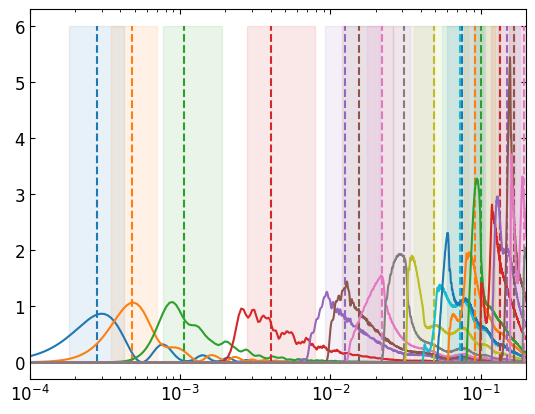

(0.0001, 0.2)

In [78]:
_,ℓkmap,_,Pi = get_plot_data(d_planck_TT, Σ_planck_TT, B_planck_TT,     CℓTT, WkℓTT, [[1, 3, 15, 15]; fill(5,2); fill(10,5); fill(20,7)])
# _,ℓkmap,_,Pi = get_plot_data(d_high_EE,   Σ_high_EE,   B_high[:,1:199], CℓEE, WkℓEE, [fill(5,2); fill(10,5); fill(20,6); 19])
# _,ℓkmap,_,Pi = get_plot_data(d_high_TE,   Σ_high_TE,   B_high[:,1:199], CℓTE, WkℓTE, [fill(5,2); fill(10,5); fill(20,6); 19])


for i = 1:size(ℓkmap,1)
    l, = semilogx(ks/h,Pi[i,:])
    plot(fill(ℓkmap[i,2],2)/h,[0,6],c=l[:get_color](),"--")
    fill_betweenx([0,6], fill(ℓkmap[i,1],2)/h, fill(ℓkmap[i,3],2)/h, color=l[:get_color](), alpha=0.1)
end
xlim(1e-4,2e-1)

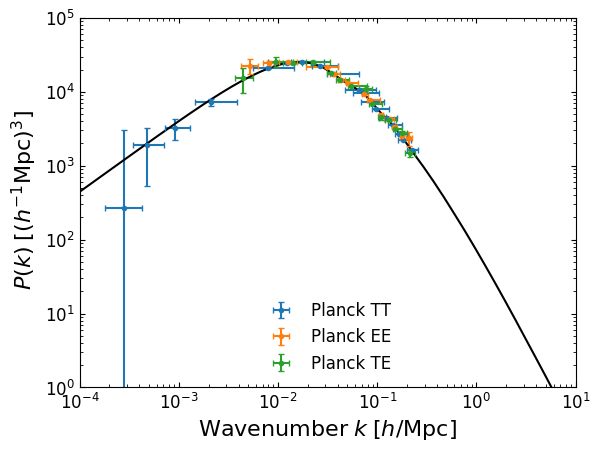

In [72]:
ks′ = logspace(-4,1)
plot(ks′,mpk[ks′],"k")


make_plot(get_plot_data(d_planck_TT, Σ_planck_TT, B_planck_TT,     CℓTT, WkℓTT, [[1, 3, 5, 20]; fill(5,2); fill(10,5); fill(20,7)])..., label="Planck TT")
make_plot(get_plot_data(d_high_EE,   Σ_high_EE,   B_high[:,1:199], CℓEE, WkℓEE, [fill(5,2); fill(10,5); fill(20,6); 19])..., label="Planck EE")
make_plot(get_plot_data(d_high_TE,   Σ_high_TE,   B_high[:,1:199], CℓTE, WkℓTE, [fill(5,2); fill(10,5); fill(20,6); 19])..., label="Planck TE")


xscale("log")
yscale("log")
legend(loc="lower center")

xlim(1e-4,10)
ylim(1,1e5)

ylabel(raw"$\; P(k) \; [(h^{-1} {\rm Mpc})^3]$")
xlabel(raw"${\rm Wavenumber} \; k \; [h/{\rm Mpc}]$")

savefig("tegfig.pdf", bbox_inches="tight")